## Using scMKL with single-cell ATAC data
Here we will run scMKL on a subset of the MCF-7 data (1,000 cells x 206,167 regions) using Hallmark groupings.

### Importing Modules
Data is read-in and saved using numpy and pickle modules.

In [1]:
# Packages needed to import data
import numpy as np
import pickle
import sys
from scipy.sparse import load_npz

# This sys command allows us to import the scMKL_src_anndata module from any directory. '..' can be replaced by any path to the repository directory
sys.path.insert(0, '..')
import src.scMKL_src_anndata as src

# Modules for viewing results
import pandas as pd
from plotnine import *

### Reading in Data
There are 4 required pieces of data (per modality) required for scMKL
- The data matrix itself with cells as rows and features as columns.
    - Can be either a Numpy Array or Scipy Sparse array (scipy.sparse.csc_array is the recommended format).  
- The sample labels in a Numpy Array.  To perform group lasso, these labels must be binary.
- Feature names in a Numpy Array. These are the names of the features corresponding with the data matrix
- A dictionary with grouping data.  The keys are the names of the groups, and the values are the corresponding features.
    - Example: {Group1: [feature1, feature2, feature3], Group2: [feature4, feature5, feature6], ...}
        - See `getting_ATAC_groupings.ipynb` for more information on pulling gene sets

In [7]:
# Reading in grouping dictionary from pickle file
group_dict = np.load('./data/MCF7_ATAC_hallmark_groupings.pkl', allow_pickle = True)

# Reading in data to be analyzed
X = load_npz('./data/MCF7_ATAC_X.npz')
cell_labels = np.load('./data/MCF7_cell_labels.npy', allow_pickle = True)
feature_names = np.load('./data/MCF7_ATAC_feature_names.npy', allow_pickle = True)

# This value for D, the number of fourier features in Z, was found to be optimal in previous literature. Generally increasing D increases accuracy, but runs slower.
D = int(np.sqrt(len(cell_labels)) * np.log(np.log(len(cell_labels))))

### Creating an AnnData Object
scMKL takes advantage of AnnData's flexible structure to create a straight-forward approach to running scMKL.
`src.Create_Adata` requires: 
- `data_type` which can be `'counts'` or `'binary'`
- `filter_features` which removes features from the `X` that are not present in the grouping
- `replication` which sets the seed for training the model
- `X` refering to the cell x feature matrix
- `cell_labels` refering to the binary array of classes cooresponding to `X` rows
- `feature_names` refering to the genes (feature names) cooresponding to `X` columns

In [9]:
adata = src.Create_Adata(X = X, feature_names = feature_names, cell_labels = cell_labels, group_dict = group_dict,
                         data_type = 'binary', D = D, filter_features = True, random_state = 100)

### Tuning Model Parameters
`sigma` refers to kernel widths and should be tuned when running scMKL with `src.Estimate_Sigma()` and `src.Optimize_Sigma`.

In [10]:
adata = src.Estimate_Sigma(adata, n_features = 200)

### Training and Evalutating Model
Here we will train and evaluate 10 models, each with a different `alpha`.

`alpha` (or lambda) is a regularization coefficient that deterimines how many groupings will be used to classify the test cells in the final model. Here, we will evalutate the model using a range of alphas (`alpha_list`) to get a range of selected groups.

In [11]:
# Creating Z matrices
adata = src.Calculate_Z(adata, n_features = 5000)

# Setting list of regularization coefficients to generate models with
alpha_list = np.round(np.linspace(2.2,0.05,10), 2)

metric_dict = {}
selected_pathways = {}
group_norms = {}
group_names = list(group_dict.keys())
predicted = {}
auroc_array = np.zeros(alpha_list.shape)

# Iterating through alpha list, training/testing models, and capturing results
for i, alpha in enumerate(alpha_list):
    
    print(f'  Evaluating model. Alpha: {alpha}', flush = True)

    adata = src.Train_Model(adata, group_size= 2*D, alpha = alpha)
    predicted[alpha], metric_dict[alpha] = src.Predict(adata, metrics = ['AUROC','F1-Score', 'Accuracy', 'Precision', 'Recall'])
    selected_pathways[alpha] = src.Find_Selected_Pathways(adata)
    group_norms[alpha] = [np.linalg.norm(adata.uns['model'].coef_[i * 2 * D: (i + 1) * 2 * D - 1]) for i in np.arange(len(group_names))]

results = {'Metrics' : metric_dict,
           'Selected_pathways' : selected_pathways,
           'Norms' : group_norms,
           'Predictions' : predicted,
           'Group_names' : group_names}

  Evaluating model. Alpha: 2.2
  Evaluating model. Alpha: 1.96
  Evaluating model. Alpha: 1.72
  Evaluating model. Alpha: 1.48
  Evaluating model. Alpha: 1.24
  Evaluating model. Alpha: 1.01
  Evaluating model. Alpha: 0.77
  Evaluating model. Alpha: 0.53
  Evaluating model. Alpha: 0.29
  Evaluating model. Alpha: 0.05


## Results

### Model Performance

  Alpha   AUROC  Number of Selected Groups                           Top Group
0  2.20  0.6983                          3         HALLMARK_HEDGEHOG_SIGNALING
1  1.96  0.7417                          5         HALLMARK_HEDGEHOG_SIGNALING
2  1.72  0.7811                          8         HALLMARK_HEDGEHOG_SIGNALING
3  1.48  0.8074                         11          HALLMARK_KRAS_SIGNALING_DN
4  1.24  0.8320                         15          HALLMARK_KRAS_SIGNALING_DN
5  1.01  0.8437                         17          HALLMARK_KRAS_SIGNALING_DN
6  0.77  0.8489                         25          HALLMARK_KRAS_SIGNALING_DN
7  0.53  0.8465                         34          HALLMARK_KRAS_SIGNALING_DN
8  0.29  0.8427                         43          HALLMARK_KRAS_SIGNALING_DN
9  0.05  0.7993                         47  HALLMARK_INTERFERON_ALPHA_RESPONSE


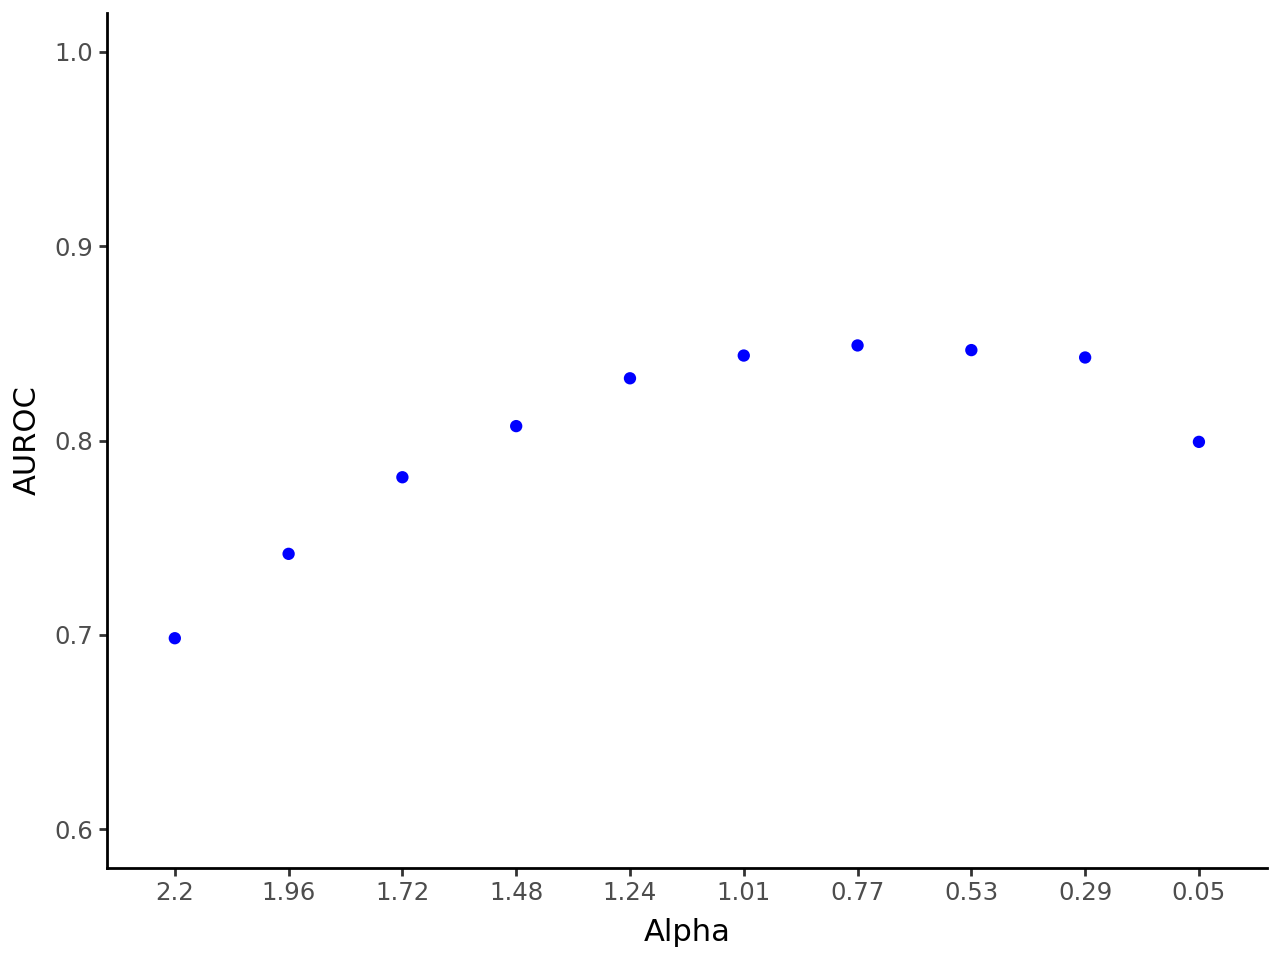

In [16]:
summary = {'Alpha' : [],
           'AUROC' : [],
           'Number of Selected Groups' : [],
           'Top Group' : []}

for alpha in alpha_list:
    summary['Alpha'].append(alpha)
    summary['AUROC'].append(results['Metrics'][alpha]['AUROC'])
    summary['Number of Selected Groups'].append(len(results['Selected_pathways'][alpha]))
    summary['Top Group'].append(*np.array(results['Group_names'])[np.where(results['Norms'][alpha] == max(results['Norms'][alpha]))])

summary = pd.DataFrame(summary)
summary['Alpha'] = pd.Categorical(summary['Alpha'], categories = summary['Alpha'])

print(summary)
(ggplot(summary, aes(x = 'Alpha', y = 'AUROC')) + geom_point(fill = 'blue', color = 'blue') + theme_classic() + ylim(0.6, 1)).show()